In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns               # For plotting
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# import io
# import random
# import time

import torch
import torch.nn as nn
# import torchvision.transforms as transforms

import clip
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation

# File Organization

In [2]:
def rename_files(source_dir):
    """
    Renames all jpg files in the source directory with their Design Labels.

    Parameters:
    source_dir: str, the path to the directory containing the jpg files.

    Returns:
    None
    """
    
    # List all files in the source directory
    files = os.listdir(source_dir)
    
    for file in files:

        # Check if the file is a jpg
        if file.endswith('.jpg') or file.endswith('.jp2'):

            # Get the file extension
            _, ext = os.path.splitext(file)

            # Skip the first VL in the file name
            first_vl_index = file.find('VL')

            # Find the next VL in the file name
            if first_vl_index != -1:
                start_index = file.find('VL', first_vl_index + 2)
                if start_index != -1:
                    end_index = file.find('.', start_index)
                    new_name = file[start_index:end_index] if end_index != -1 else file[start_index:]

                    # Rename the file
                    original_file_path = os.path.join(source_dir, file)
                    new_file_path = os.path.join(source_dir, new_name + ext)
                    os.rename(original_file_path, new_file_path)


def process_filenames(folder_path):
    # Iterate through each file in the folder
    for filename in os.listdir(folder_path):
        # Split the filename into parts based on the underscore
        parts = filename.split('_')
        
        # Ensure the filename has the correct number of parts
        if len(parts) >= 4:
            # Extract the part between the second and third underscore
            target_part = parts[2]
            
            # Replace the dot with an underscore in the extracted part
            new_part = target_part.replace('.', '_')
            
            # Get the file extension
            file_extension = os.path.splitext(filename)[1]
            
            # Construct the new filename
            new_filename = f"{new_part}{file_extension}"
            
            # Print or rename the file as needed
            print(f"Original filename: {filename}")
            print(f"Processed filename: {new_filename}\n")
            
            # To actually rename the file, uncomment the next line
            os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))

# # Example usage
# folder_path = '/Users/ilerisoy/Downloads/Classics/models'
# process_filenames(folder_path)


# Helpers

In [3]:
def open_image(image_path, convert_mode="RGB"):
    """
    Opens an image from the given path.

    Parameters:
    image_path: str, the path to the image.
    convert_mode: str, the mode to convert the image to. Options are "RGB" and "L".

    Returns:
    image: Image, the opened image.
    """

    assert convert_mode in ["RGB", "L"], "Invalid convert mode. Options are 'RGB' and 'L'."
    
    # Open the image
    image = Image.open(image_path)

    # Convert the image to specified mode
    image = image.convert(convert_mode)

    return image

def display_image(image):
    """
    Displays the image.

    Parameters:
    image: Image, the image to display.

    Returns:
    None
    """

    image.show()

def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette


def resize_images_in_folder(source_folder, destination_folder, size=(336, 336)):
    """
    Iterates through a given folder, opens each image file, resizes it to the specified size,
    and saves it to the specified destination folder.

    Parameters:
    - source_folder: str, the folder containing the images to resize.
    - destination_folder: str, the folder to save the resized images.
    - size: tuple, the target size for resizing (default is (336, 336)).

    Returns:
    - None
    """
    # Ensure the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Iterate through each file in the source folder
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        
        # Check if the file is an image
        try:
            with Image.open(file_path) as img:
                # Resize the image
                img_resized = img.resize(size, Image.ANTIALIAS)
                
                # Save the resized image to the destination folder
                save_path = os.path.join(destination_folder, filename)
                img_resized.save(save_path)
                print(f"Resized and saved {filename} to {save_path}")
        except IOError:
            print(f"Skipping non-image file: {filename}")


def convert_jp2_to_jpg(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith('.jp2'):
            # Open the jp2 file
            jp2_path = os.path.join(folder_path, filename)
            img = Image.open(jp2_path)
            
            # Convert the filename to .jpg
            new_filename = os.path.splitext(filename)[0] + '.jpg'
            jpg_path = os.path.join(folder_path, new_filename)
            
            # Save the image as a jpg
            img.convert('RGB').save(jpg_path, 'JPEG')
            
            # Optionally, delete the original .jp2 file
            # os.remove(jp2_path)
            
            print(f"Converted {filename} to {new_filename}")

# Functions

In [4]:
from torchvision.transforms import ToPILImage

def image_encoder(image, model, transform, name=None):
    """
    Use CLIP model to encode the image and save the tranformed version.
    First resizes the image to 224x224, then normalizes it, and finally encodes it.
    Then, encodes the image into a 512-dimensional feature vector.
    
    
    Parameters:
    - image: PIL.Image object, the image to encode.
    - model: CLIP model, the model used for encoding.
    - transform: CLIP transform, the transformation to required for CLIP.
    - save_folder: str, the folder to save the transformed image.
    - filename: str, the name of the file to save the transformed image as.

    Returns:
    - image_features: torch.Tensor, the encoded image.
    """

    # Load the CLIP model
    model = model.eval().to(DEVICE)

    # Preprocess the image
    image = transform(image).unsqueeze(0).to(DEVICE)

    # Convert the tensor to a PIL image
    to_pil = ToPILImage()
    image_pil = to_pil(image.squeeze(0))

    # Save the transformed image
    if name is not None:
        image_pil.save(os.path.join("/Users/ilerisoy/Downloads/Classics/all/transformed", name))

    # Encode the image
    with torch.no_grad():
        image_features = model.encode_image(image)

    return image_features

def create_reference_embeddings(source_dir, CLIP_model, CLIP_transform, convert_mode):
    """
    Creates the image embeddings for the images in the source directory and saves together with labels.
    
    Parameters:
    - source_dir: str, the path to the directory containing the images.
    - CLIP_model: CLIP model, the CLIP model to use for encoding.
    - CLIP_transform: CLIP transforms, the CLIP transformation to apply to the images.
    - convert_mode: str, the mode to convert the image to. Options are "RGB" and "L".
    
    Returns:
    None
    """

    # Get the list of files in the source directory
    sub_files = os.listdir(source_dir)

    # Initialize the list of image features and labels
    design_features_list = []
    design_labels_list = []

    for file in sub_files:
        if file == ".DS_Store":
            continue
        print(f"Processing {file}...")

        # Get the path to the folder containing the images
        image_path = os.path.join(source_dir, file)

        # Load the images from the folder
        image = open_image(image_path, convert_mode)

        # Embed the image
        image_features = image_encoder(image, CLIP_model, CLIP_transform, name=file)

        # Append the image features and labels to the lists
        design_features_list.append(image_features)
        design_labels_list.append(file)

    # Save the image features and labels
    data_dir = os.path.dirname(source_dir)
    base = os.path.basename(data_dir)
    
    with open(os.path.join(data_dir, f"{base}_embeddings_{convert_mode}.pkl"), 'wb') as f:
        pickle.dump(design_features_list, f)
    with open(os.path.join(data_dir, f"{base}_labels_{convert_mode}.pkl"), 'wb') as f:
        pickle.dump(design_labels_list, f)

def get_segmentation_mask(image, processor, model):
    """
    Function to segment clothes in an image.

    Parameters:
    - image: PIL.Image object, the image to segment.
    - processor: SegformerImageProcessor object, the processor used to preprocess the image.
    - model: AutoModelForSemanticSegmentation object, the model used to segment the image.

    Returns:
    - pred_seg: torch.Tensor, the segmented image.
    """
    inputs = processor(images=image, return_tensors="pt")

    outputs = model(**inputs)
    logits = outputs.logits.cpu()

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    pred_seg = upsampled_logits.argmax(dim=1)[0]

    # Create a mask for the labels 4, 5, 6, and 7
    mask = (pred_seg == 4) | (pred_seg == 5) | (pred_seg == 6) | (pred_seg == 7) | (pred_seg == 8) | (pred_seg == 16) | (pred_seg == 17)

    # Set all other labels to 0
    pred_seg[~mask] = 0

    # Set the labels 4, 5, 6, and 7 to 255
    pred_seg[mask] = 255

    return pred_seg
    
    # plt.imshow(pred_seg)

# Configuration

In [5]:
# Device
DEVICE = "mps"

# Source directory containing the scraped folders
data_dir = "/Users/ilerisoy/Downloads/Classics/all"
dataset = os.path.basename(data_dir)
designs_dir = os.path.join(data_dir, "designs")

# Color mode for the images
convert_mode = "RGB"

# Load the CLIP model
CLIP_model, CLIP_transform = clip.load("ViT-L/14@336px")

# Segmentation model initialization
seg_processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
seg_model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/Users/ilerisoy/anaconda3/envs/pg/lib/python3.8/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [6]:
# Create the reference embeddings
create_reference_embeddings(designs_dir, CLIP_model, CLIP_transform, convert_mode)

# Load the design database embeddings and labels
with open(os.path.join(data_dir, f"{dataset}_embeddings_{convert_mode}.pkl"), 'rb') as f:
    design_embeddings = pickle.load(f)
with open(os.path.join(data_dir, f"{dataset}_labels_{convert_mode}.pkl"), 'rb') as f:
    design_labels = pickle.load(f)

print(f'Total number of embeddings: {len(design_embeddings)}')
print(f'Type of design embeddings: {type(design_embeddings)}')
print(f'Design Labels: {design_labels}')
print(f'Length of Design Labels: {len(design_labels)}')

Processing VL0H703_131.jp2...


/Users/ilerisoy/anaconda3/envs/pg/lib/python3.8/site-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


Processing VL48350_031.jp2...
Processing VL0H522_093.jp2...
Processing VL00014_308.jp2...
Processing VL50950_176.jp2...
Processing VL04339_090.jp2...
Processing VL76950_202.jp2...
Processing VL0H876_078.jp2...
Processing VLH1498_020.jp2...
Processing VL03999_086.jp2...
Processing VL03639_212.jp2...
Processing VL03636_136.jp2...
Processing VL65450_048.jp2...
Processing VL01681_063.jp2...
Processing VL04918_075.jp2...
Processing VL04787_082.jp2...
Processing VL0H596_111.jp2...
Processing VL03327_129.jp2...
Processing VL01003_124.jp2...
Processing VL00736_199.jp2...
Processing VL00535_145.jp2...
Processing VL0H600_050.jp2...
Processing VL00017_342.jp2...
Processing VL00052_153.jp2...
Processing VL00864_001.jp2...
Processing VL01003_087.jp2...
Processing VL03143_077.jp2...
Processing VL02316_117.jp2...
Processing VL03499_055.jp2...
Processing VLH1003_135.jp2...
Processing VL00017_346.jp2...
Processing VL00924_247.jp2...
Processing VL00511_279.jp2...
Processing VLA0455_030.jp2...
Processing

## Compare Similarities

In [7]:
source_dir = os.path.join(data_dir, "models")
sub_files = os.listdir(source_dir)

# Initialize the vars to keep track of stats
match = 0
ds_strore_count = 0
failed_files = []
all_scores = []
all_ranks = []
for file in sub_files:
    if file == ".DS_Store":
        ds_strore_count += 1
        continue

    # Get the path to the folder containing the images
    image_path = os.path.join(source_dir, file)

    # Load the images from the folder
    image = open_image(image_path)
    
    # Get cloth segmentation mask
    segmented_image = get_segmentation_mask(image, seg_processor, seg_model)

    # Convert the tensor to a numpy array
    segmented_image = segmented_image.cpu().numpy()
    segmented_image = np.array(segmented_image, dtype=np.uint8)

    # Create a 3-channel mask
    segmented_image_3ch = np.stack([segmented_image] * 3, axis=-1)

    # Apply the mask to the input image
    filtered_image_np = np.where(segmented_image_3ch == 255, np.array(image), 0)

    # Find the bounding box of the segmentation mask
    coords = np.column_stack(np.where(segmented_image == 255))
    # Check if the segmentation mask is all black
    if coords.size > 0:
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)

        # Crop the original image using the bounding box coordinates
        cropped_image = filtered_image_np[y_min:y_max+1, x_min:x_max+1]

        # Convert the cropped image to a numpy array if needed
        cropped_image_np = np.array(cropped_image)

        # Display the Image
        cropped_image_pil = Image.fromarray(cropped_image_np, mode='RGB')
    else:
        print("The segmentation mask is all black. Skipping cropping operation.")
        # Convert the filtered image back to PIL format
        cropped_image_pil = Image.fromarray(filtered_image_np, mode='RGB')

        cropped_image_pil = cropped_image_pil.convert("RGB")
        # continue
    
    # Check if the save folder exists
    save_folder = os.path.join(data_dir, "cropped_images")
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    # Save the filtered image
    cropped_image_pil.save(save_folder + f"/{file[:-4]}_filtered.jpg")

    # Embed the image
    image_features = image_encoder(cropped_image_pil, CLIP_model, transform=CLIP_transform)

    # Do cosine similarity with the design embeddings
    similarities = [torch.nn.functional.cosine_similarity(image_features, t) for t in design_embeddings]
    similarities = torch.stack(similarities)
    
    # Sort the similarities and design labels
    sorted_similarities = similarities.T.topk(len(design_embeddings))
    sorted_design_labels = [design_labels[i] for i in sorted_similarities.indices[0]]

    # Get top k similar designs and labels
    k = 5
    top_k_similarities = sorted_similarities.values[:k]
    top_k_design_labels = sorted_design_labels[:k]

    # Check if the design label is in the top k similar designs
    temp_match = match
    rank = 0
    for design_label in top_k_design_labels:
        rank += 1
        if design_label[:6] == file[:6]:
            match += 1
            print(f"MATCH: {match} in {file} | RANK: {rank} \nTop K similarity values: {top_k_similarities} \nDesign Labels: {top_k_design_labels} \n")
            break
        
    
    if temp_match == match:
        rank = -1
        print(f"######## in {file} | ###### \nTop K similarity values: {top_k_similarities} \nDesign Labels: {top_k_design_labels} \n")
        failed_files.append(file)
    
    all_scores.append(top_k_similarities)
    all_ranks.append(rank)
    

print(f"Match: {match}/{len(sub_files)-ds_strore_count}")
print(f"Failed files: {failed_files}")

MATCH: 1 in VL0H703_131.jp2 | RANK: 2 
Top K similarity values: tensor([[0.7600, 0.7594, 0.7568, 0.7479, 0.7449, 0.7424, 0.7407, 0.7390, 0.7340,
         0.7309, 0.7308, 0.7306, 0.7298, 0.7243, 0.7215, 0.7199, 0.7179, 0.7173,
         0.7159, 0.7125, 0.7120, 0.7119, 0.7117, 0.7112, 0.7109, 0.7102, 0.7093,
         0.7091, 0.7084, 0.7049, 0.7039, 0.7032, 0.7028, 0.7027, 0.7010, 0.7001,
         0.6999, 0.6996, 0.6994, 0.6986, 0.6983, 0.6980, 0.6974, 0.6952, 0.6950,
         0.6950, 0.6944, 0.6942, 0.6937, 0.6932, 0.6928, 0.6928, 0.6923, 0.6922,
         0.6922, 0.6922, 0.6922, 0.6922, 0.6922, 0.6922, 0.6922, 0.6922, 0.6922,
         0.6922, 0.6922, 0.6922, 0.6922, 0.6922, 0.6922, 0.6922, 0.6922, 0.6922,
         0.6922, 0.6922, 0.6922, 0.6922, 0.6914, 0.6914, 0.6912, 0.6909, 0.6904,
         0.6903, 0.6900, 0.6900, 0.6896, 0.6890, 0.6886, 0.6882, 0.6879, 0.6879,
         0.6878, 0.6876, 0.6874, 0.6855, 0.6847, 0.6843, 0.6832, 0.6829, 0.6825,
         0.6824, 0.6822, 0.6820, 0.6819, 0.68

In [8]:
# save the results
with open(os.path.join(data_dir, f"{dataset}_results_{convert_mode}.pkl"), 'wb') as f:
    pickle.dump(all_scores, f)
with open(os.path.join(data_dir, f"{dataset}_ranks_{convert_mode}.pkl"), 'wb') as f:
    pickle.dump(all_ranks, f)

# Analysis of The Performance

### Average Scores and Ranks

Max score: 1.0, Min score: 0.433260053396225


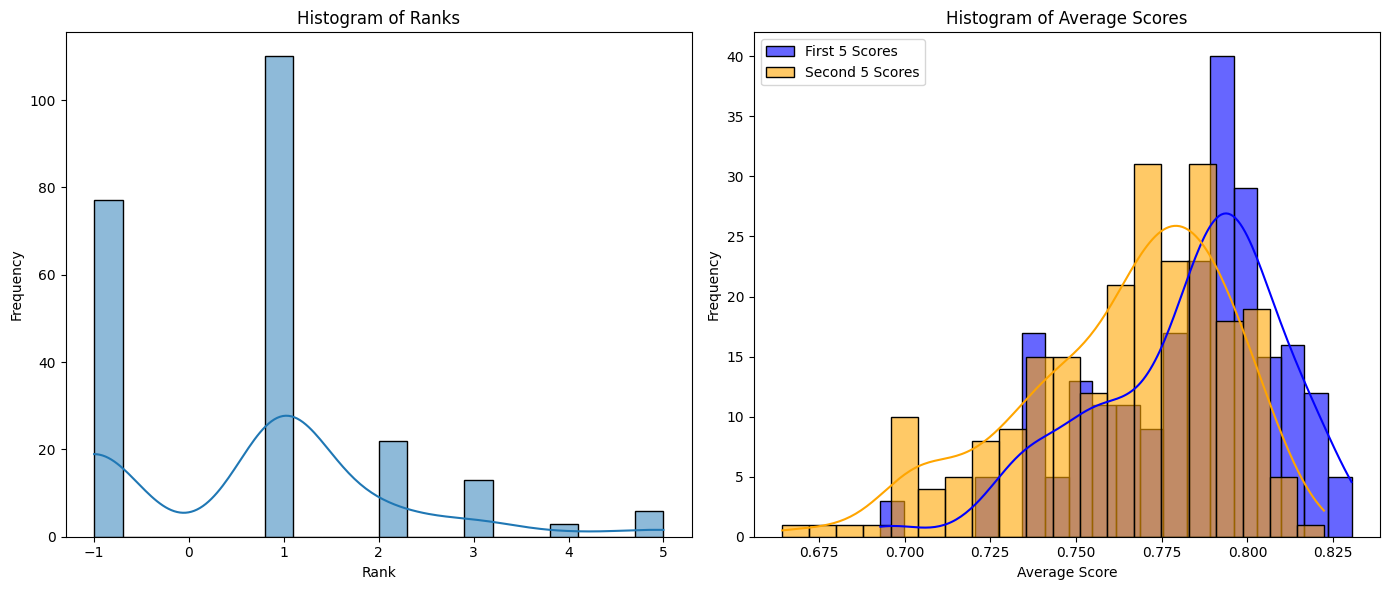

In [12]:
# # Load the design database embeddings and labels
# with open(os.path.join(data_dir, f"{dataset}_results_{convert_mode}.pkl"), 'rb') as f:
#     all_scores = pickle.load(f)
# with open(os.path.join(data_dir, f"{dataset}_ranks_{convert_mode}.pkl"), 'rb') as f:
#     all_ranks = pickle.load(f)

# Convert each tensor in all_scores to a numpy array and remove the extra dimension
all_scores = [scores.cpu().numpy().reshape(-1) for scores in all_scores]

print(f"Max score: {np.max(all_scores)}, Min score: {np.min(all_scores)}")

# Check for NaN values and replace them with 0
all_scores = [np.nan_to_num(scores, nan=0.0) for scores in all_scores]

# Ensure there are at least 10 scores in each entry before calculating averages
valid_scores = [scores for scores in all_scores if len(scores) >= 10]

# Filter out scores above 0.99
filtered_scores = [scores[scores <= 0.99] for scores in valid_scores]

# Calculate average scores for the first 5 and second 5 scores for each entry
avg_first_5_scores = [np.mean(scores[:5]) for scores in filtered_scores if len(scores) >= 5]
avg_second_5_scores = [np.mean(scores[5:10]) for scores in filtered_scores if len(scores) >= 10]

# Convert ranks to numpy array for easier calculations
all_ranks = np.array(all_ranks)

# Plot histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(all_ranks, bins=20, kde=True)
plt.title('Histogram of Ranks')
plt.xlabel('Rank')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(avg_first_5_scores, bins=20, kde=True, label='First 5 Scores', color='blue', alpha=0.6)
sns.histplot(avg_second_5_scores, bins=20, kde=True, label='Second 5 Scores', color='orange', alpha=0.6)
plt.title('Histogram of Average Scores')
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print basic statistics for average scores
mean_first_5 = np.mean(avg_first_5_scores)
median_first_5 = np.median(avg_first_5_scores)
std_first_5 = np.std(avg_first_5_scores)

mean_second_5 = np.mean(avg_second_5_scores)
median_second_5 = np.median(avg_second_5_scores)
std_second_5 = np.std(avg_second_5_scores)

### Score Distributions of Correct and Misclasifications

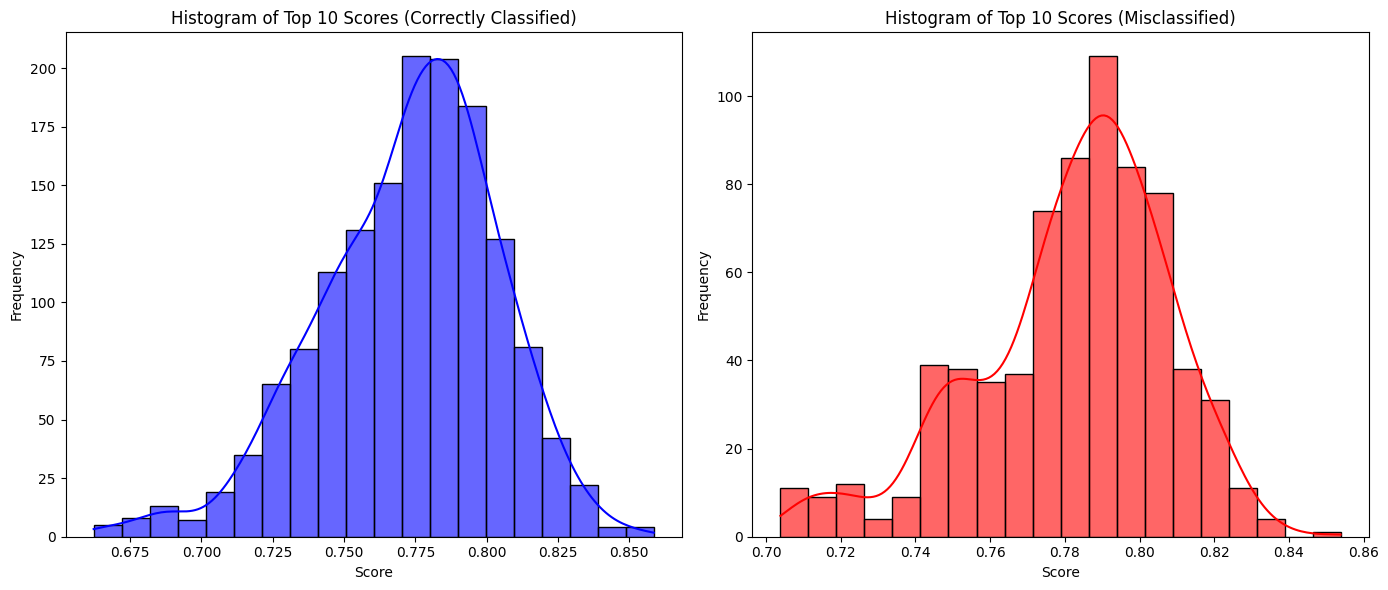

In [13]:
# # Load the design database embeddings and labels
# with open(os.path.join(data_dir, f"{dataset}_results_{convert_mode}.pkl"), 'rb') as f:
#     all_scores = pickle.load(f)
# with open(os.path.join(data_dir, f"{dataset}_ranks_{convert_mode}.pkl"), 'rb') as f:
#     all_ranks = pickle.load(f)

# # Convert each tensor in all_scores to a numpy array and remove the extra dimension
# all_scores = [scores.cpu().numpy().reshape(-1) for scores in all_scores]

# Flatten all scores into a single array for the unnormalized histogram
all_scores_flat = np.concatenate(all_scores)

# Find global max and min scores for normalization
max_score = max(np.max(scores) for scores in all_scores)
min_score = min(np.min(scores) for scores in all_scores)

# Normalize the scores using Min-Max normalization
all_scores_normalized = [(scores - min_score) / (max_score - min_score) for scores in all_scores]

# Flatten all normalized scores into a single array for the normalized histogram
all_scores_normalized_flat = np.concatenate(all_scores_normalized)

# Convert ranks to numpy array for easier calculations
all_ranks = np.array(all_ranks)

# Filter scores based on ranks and remove scores above 0.99
correctly_classified_scores = [scores[:10][scores[:10] <= 0.99] for scores, rank in zip(all_scores, all_ranks) if rank > 0]
misclassified_scores = [scores[:10][scores[:10] <= 0.99] for scores, rank in zip(all_scores, all_ranks) if rank == -1]

# Flatten the filtered scores
correctly_classified_scores_flat = np.concatenate(correctly_classified_scores)
misclassified_scores_flat = np.concatenate(misclassified_scores)

# Plot histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(correctly_classified_scores_flat, bins=20, kde=True, color='blue', alpha=0.6)
plt.title('Histogram of Top 10 Scores (Correctly Classified)')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(misclassified_scores_flat, bins=20, kde=True, color='red', alpha=0.6)
plt.title('Histogram of Top 10 Scores (Misclassified)')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()